# Overview

### Target 
1. Reduce the number of parameters 

### Result 
1. Parameters: 9,520
2. Best Training Accuracy: 98.79
3. Best Test Accuracy: 98.79

### Analysis 
1. Loss curve shows overfitting


# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
import matplotlib.pyplot as plt

# Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Model


In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    # Convolution Block 1
    self.convblock1 = nn.Sequential(
        nn.Conv2d(in_channels=1,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    # Convolution Block 2
    self.convblock2 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    self.pool1 = nn.Sequential(
        nn.MaxPool2d(2, 2)
    )

    # Convolution Block 3
    self.convblock3 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    # Convolution Block 4
    self.convblock4 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    # Convolution Block 5
    self.convblock5 = nn.Sequential(
        nn.Conv2d(in_channels=16,out_channels=16,kernel_size=(3,3),padding = 0, bias = False),
        nn.ReLU(),
    )

    # Global average pooling layer
    self.gap = nn.Sequential(
        nn.AvgPool2d(kernel_size=6),
        nn.Conv2d(in_channels=16,out_channels=10,kernel_size=(1,1),padding = 0, bias = False)
    )
  
  def forward(self, x):

    x = self.convblock1(x)
    x = self.convblock2(x)
    x = self.pool1(x)

    x = self.convblock3(x)
    x = self.convblock4(x)    
    x = self.convblock5(x)
    
    x = self.gap(x)
    x = x.view(-1,10)
    
    return F.log_softmax(x,dim = -1)


# Model Parameters

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,304
              ReLU-4           [-1, 16, 24, 24]               0
         MaxPool2d-5           [-1, 16, 12, 12]               0
            Conv2d-6           [-1, 16, 10, 10]           2,304
              ReLU-7           [-1, 16, 10, 10]               0
            Conv2d-8             [-1, 16, 8, 8]           2,304
              ReLU-9             [-1, 16, 8, 8]               0
           Conv2d-10             [-1, 16, 6, 6]           2,304
             ReLU-11             [-1, 16, 6, 6]               0
        AvgPool2d-12             [-1, 16, 1, 1]               0
           Conv2d-13             [-1, 10, 1, 1]             160
Total params: 9,520
Trainable para

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  
  train_losses.append(loss)
  train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.6042828559875488 Batch_id=468 Accuracy=29.42: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]



Test set: Average loss: 0.5045, Accuracy: 8468/10000 (84.68%)

EPOCH: 1


Loss=0.20994947850704193 Batch_id=468 Accuracy=88.91: 100%|██████████| 469/469 [00:15<00:00, 30.02it/s]



Test set: Average loss: 0.2567, Accuracy: 9212/10000 (92.12%)

EPOCH: 2


Loss=0.2059086561203003 Batch_id=468 Accuracy=94.00: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]



Test set: Average loss: 0.1414, Accuracy: 9566/10000 (95.66%)

EPOCH: 3


Loss=0.08047003298997879 Batch_id=468 Accuracy=95.71: 100%|██████████| 469/469 [00:15<00:00, 29.71it/s]



Test set: Average loss: 0.1293, Accuracy: 9597/10000 (95.97%)

EPOCH: 4


Loss=0.07622278481721878 Batch_id=468 Accuracy=96.48: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]



Test set: Average loss: 0.0895, Accuracy: 9734/10000 (97.34%)

EPOCH: 5


Loss=0.1342475265264511 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:16<00:00, 29.22it/s]



Test set: Average loss: 0.0759, Accuracy: 9771/10000 (97.71%)

EPOCH: 6


Loss=0.03979145735502243 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:16<00:00, 29.27it/s]



Test set: Average loss: 0.0687, Accuracy: 9793/10000 (97.93%)

EPOCH: 7


Loss=0.0948227047920227 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:16<00:00, 29.19it/s]



Test set: Average loss: 0.0683, Accuracy: 9801/10000 (98.01%)

EPOCH: 8


Loss=0.05017464980483055 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]



Test set: Average loss: 0.0639, Accuracy: 9799/10000 (97.99%)

EPOCH: 9


Loss=0.016141096130013466 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]



Test set: Average loss: 0.0577, Accuracy: 9817/10000 (98.17%)

EPOCH: 10


Loss=0.008062117733061314 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:16<00:00, 29.30it/s]



Test set: Average loss: 0.0519, Accuracy: 9837/10000 (98.37%)

EPOCH: 11


Loss=0.009180867113173008 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:15<00:00, 29.46it/s]



Test set: Average loss: 0.0482, Accuracy: 9849/10000 (98.49%)

EPOCH: 12


Loss=0.05000864341855049 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]



Test set: Average loss: 0.0468, Accuracy: 9850/10000 (98.50%)

EPOCH: 13


Loss=0.025039950385689735 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]



Test set: Average loss: 0.0450, Accuracy: 9855/10000 (98.55%)

EPOCH: 14


Loss=0.005547644570469856 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:15<00:00, 29.32it/s]



Test set: Average loss: 0.0502, Accuracy: 9838/10000 (98.38%)

EPOCH: 15


Loss=0.05530841276049614 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 29.20it/s]



Test set: Average loss: 0.0474, Accuracy: 9860/10000 (98.60%)

EPOCH: 16


Loss=0.04882160946726799 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]



Test set: Average loss: 0.0460, Accuracy: 9854/10000 (98.54%)

EPOCH: 17


Loss=0.040950290858745575 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:16<00:00, 29.07it/s]



Test set: Average loss: 0.0472, Accuracy: 9855/10000 (98.55%)

EPOCH: 18


Loss=0.019350523129105568 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]



Test set: Average loss: 0.0429, Accuracy: 9859/10000 (98.59%)

EPOCH: 19


Loss=0.008612063713371754 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 29.00it/s]



Test set: Average loss: 0.0350, Accuracy: 9879/10000 (98.79%)



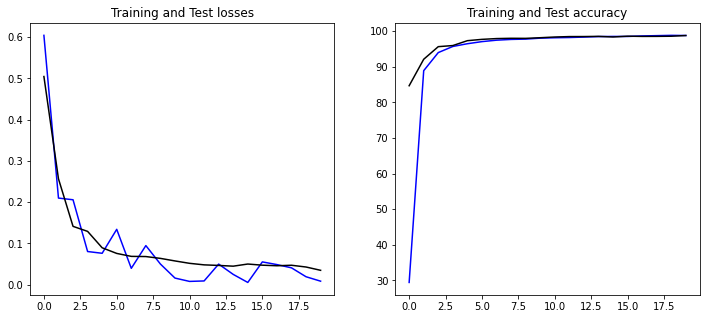

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(train_losses, c='blue')
ax1.plot(test_losses, c='black')
ax1.title.set_text('Training and Test losses')

ax2.plot(train_acc, c='blue')
ax2.plot(test_acc, c='black')
ax2.title.set_text('Training and Test accuracy')